In [1]:
### Libraries required ###
#########################################################

import numpy as np
import matplotlib.pyplot as plt

### Initialization of variables ###
#########################################################

mu = 1

### Load computational mesh (from .mat files) ###
#########################################################

import importlib
import mesh.mesh_matrices_mat
importlib.reload(mesh.mesh_matrices_mat)  # Force recharge of the module
from mesh.mesh_matrices_mat import load_mesh

In [2]:
matrix_number = 1 # User-defined matrix number
degree = 1  # User-defined degree

X, T, Tb_Dirichlet = load_mesh(matrix_number, degree) # Load the matrices and initialize them as variables

Matrices loaded from 'mesh/mesh1_P1.mat' with 0-indexed connectivity.


In [3]:
"""if X is not None: #To compare with Matlab
    print(f"\n Loaded file: mesh{matrix_number}_P{degree}.mat")
    print("\nX (Nodal Coordinates):\n", X)
    print("\nT (Mesh Connectivity):\n", T)
    print("\nTb_Dirichlet (Dirichlet Boundary Conditions):\n", Tb_Dirichlet)"""

nOfElements = T.shape[0]

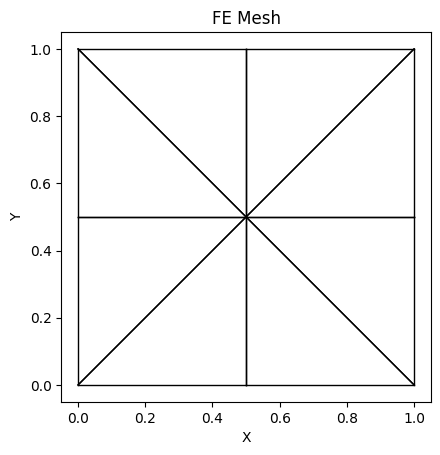

In [4]:
import mesh.mesh_plot
importlib.reload(mesh.mesh_plot)  # Force recharge of the module
from mesh.mesh_plot import plot_mesh

plot_mesh(X, T,option='', nodesNum='all')  # Mesh representation in a 2D plot

In [5]:
### HDG preprocess ###
#########################################################

import hdgCommon.hdg_preprocess
from hdgCommon.hdg_preprocess import hdg_preprocess

F, infoFaces = hdg_preprocess(T)  # Process the mesh
nOfFaces = np.max(F)+1  # Find the total number of faces

"""print("\nF:\n", F)
print("\ninfoFaces:\n", infoFaces)
print("Total Number of Faces:", nOfFaces)"""

'print("\nF:\n", F)\nprint("\ninfoFaces:\n", infoFaces)\nprint("Total Number of Faces:", nOfFaces)'

In [6]:
### Viscosity parameter ###
#########################################################

muElem = mu * np.ones(nOfElements)

In [7]:
### Stabilization parameter ###
#########################################################

tau = np.ones((nOfElements,3))

In [8]:
### Computation ###
#########################################################

import referenceElement
from referenceElement.createReferenceElementTri import create_reference_element_tri

referenceElement = create_reference_element_tri(degree)

In [9]:
import pprint
pprint.pprint(referenceElement)

print("\nLoop in elements...\n")

import hdgPoisson.hdgMatrixPoisson
from hdgPoisson.hdgMatrixPoisson import hdgMatrixPoisson

K, f, QQ, UU, Qf, Uf = hdgMatrixPoisson(muElem,X,T,F,referenceElement,infoFaces,tau)


print("===== GLOBAL MATRIX K (disperse) =====")
print(K)
print("Shape:", K.shape)
print("Number of non null elements:", K.nnz)

print("\n===== GLOBAL SOURCE VERCTOR f =====")
print(f)
print("Shape:", f.shape)

print("\n===== LOCAL MATRIXES QQ =====")
for i, QQe in enumerate(QQ):
    print(f"Element {i}:")
    print(QQe.toarray())

print("\n===== LOCAL MATRIXES UU =====")
for i, UUe in enumerate(UU):
    print(f"Element {i}:")
    print(UUe.toarray())

print("\n===== LOCAL SOURCE VERCTORS Qf =====")
for i, Qfe in enumerate(Qf):
    print(f"Element {i}:")
    print(Qfe.flatten())

print("\n===== GLOBAL SOURCE VERCTORS Uf =====")
for i, Ufe in enumerate(Uf):
    print(f"Element {i}:")
    print(Ufe.flatten())

{'IPcoordinates': array([[-0.33333333, -0.33333333],
       [-0.88056826, -0.05971587],
       [-0.05971587, -0.05971587],
       [-0.05971587, -0.88056826],
       [ 0.59485397, -0.79742699],
       [-0.79742699, -0.79742699],
       [-0.79742699,  0.59485397]]),
 'IPcoordinates1d': array([ 0.        ,  0.77459667, -0.77459667]),
 'IPweights': array([0.45      , 0.26478831, 0.26478831, 0.26478831, 0.25187836,
       0.25187836, 0.25187836]),
 'IPweights1d': array([0.88888889, 0.55555556, 0.55555556]),
 'N': array([[0.33333333, 0.33333333, 0.33333333],
       [0.47014206, 0.05971587, 0.47014206],
       [0.05971587, 0.47014206, 0.47014206],
       [0.47014206, 0.47014206, 0.05971587],
       [0.10128651, 0.79742699, 0.10128651],
       [0.79742699, 0.10128651, 0.10128651],
       [0.10128651, 0.10128651, 0.79742699]]),
 'N1d': array([[0.5       , 0.5       ],
       [0.11270167, 0.88729833],
       [0.88729833, 0.11270167]]),
 'N1dxi': array([[-0.5,  0.5],
       [-0.5,  0.5],
       [

In [10]:
### Dirichlet BC ###
# Dirichlet face nodal coordinates

nOfFaceNodes = degree + 1

nOfInteriorFaces = infoFaces["intFaces"].shape[0]
nOfExteriorFaces = infoFaces["extFaces"].shape[0]

import poisson.analyticalPoisson
from poisson.analyticalPoisson import analytical_poisson

import hdgCommon.computeProjectionFaces
from hdgCommon.computeProjectionFaces import compute_projection_faces

uDirichlet = compute_projection_faces(analytical_poisson, infoFaces["extFaces"], X, T, referenceElement)
"""
print("\nDirichlet boundary condition (uDirichlet):\n", uDirichlet)
"""
dofDirichlet = np.arange(nOfInteriorFaces * nOfFaceNodes, 
                         nOfInteriorFaces * nOfFaceNodes + nOfExteriorFaces * nOfFaceNodes)
dofUnknown = np.arange(nOfInteriorFaces * nOfFaceNodes)
# The previous dofs are 0-indexed

In [ ]:
# Extract submatrixes and source vector (CSR compatible)
K_ud = K[dofUnknown[:, None], dofDirichlet]
f_reduced = f[dofUnknown] - K_ud @ uDirichlet
K_reduced = K[dofUnknown[:, None], dofUnknown]

K_reduced_dense = K_reduced.toarray() # convert to dense matrix to solve with numpy

In [13]:
### Face solution ###

from numpy.linalg import solve
lambda_vals = solve(K_reduced_dense, f_reduced)

"""print("\nLambda values (solution for the unknowns):\n", lambda_vals)"""  

# complete solution (lambda + uDirichlet)
uhat = np.zeros(K.shape[0])
uhat[dofUnknown] = lambda_vals
uhat[dofDirichlet] = uDirichlet

"""print("\nComplete solution (uhat):\n", uhat)"""

'print("\nComplete solution (uhat):\n", uhat)'

In [14]:
### Elemental solution ###

import hdgPoisson.computeElementsSolution
from hdgPoisson.computeElementsSolution import compute_elements_solution

print("Calculating element by element solution...")
u, q = compute_elements_solution(uhat, UU, QQ, Uf, Qf, F)


"""print("\nu:\n", u)
print("q:\n", q)"""

Calculating element by element solution...


'print("\nu:\n", u)\nprint("q:\n", q)'

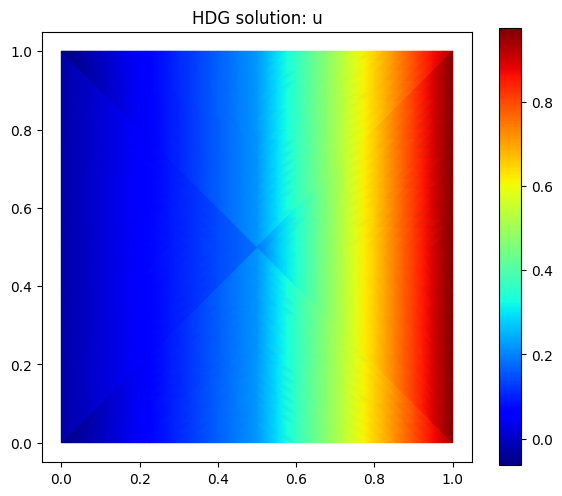

In [15]:
from Utilities.plotDiscontinousSolution import plot_discontinuous_solution

fig, ax, tpc = plot_discontinuous_solution(X, T, u, referenceElement, n_deg_ref=20)

plt.colorbar(tpc, ax=ax)
plt.tight_layout()
plt.show()  


In [16]:
### Local postprocess for superconvergence ###

print("\nPerforming local postprocess...\n")

from referenceElement.createReferenceElementTriStar import create_reference_element_tri_star
from hdgCommon.HDGPostProcess import HDG_postprocess

referenceElement_star = create_reference_element_tri_star(referenceElement)
#print("Reference Element Star:\n", referenceElement_star)

u_star = HDG_postprocess(X, T, u, -q, referenceElement_star)
"""print("\nPostprocessed solution (u_star):\n", u_star) """


Performing local postprocess...



'print("\nPostprocessed solution (u_star):\n", u_star) '

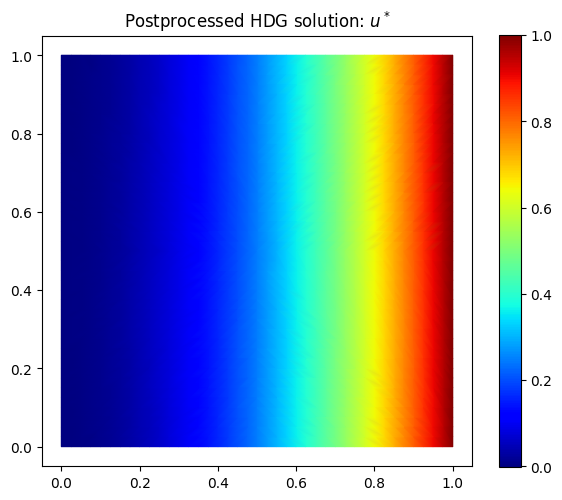

In [17]:
### Plots postprocess solution ###

from Utilities.plotPostProcessedSolution import plot_postprocessed_solution

fig, ax, tpc = plot_postprocessed_solution(X, T, u_star, referenceElement_star, n_deg_ref=20)

plt.colorbar(tpc, ax=ax)
plt.tight_layout()
plt.show()

In [18]:
### Errors ###
#########################################################

from Utilities.computeL2Norm import compute_L2_norm
from Utilities.computeL2NormPostProcessed import compute_L2_norm_postprocess

import numpy as np

### Define the analytical solution (as a function) ###
u_ex = analytical_poisson  # Assume this is a Python function: def analytical_poisson(xy): ...

### Error for the HDG solution ###
error = compute_L2_norm(referenceElement, X, T, u, u_ex)
print(f"Error HDG = {error:.6e}")

### Error for the postprocessed solution ###
error_post = compute_L2_norm_postprocess(referenceElement_star, X, T, u_star, u_ex)
print(f"Error HDG postprocessed = {error_post:.6e}")
print()

Error HDG = 1.482719e-02
Error HDG postprocessed = 1.614555e-03

